In [3]:
#@title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License.

#@title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License.

# Welcome to Apache Beam!

This notebook will be your introductory guide to Beam's main concepts and its uses. This tutorial **does not** assume any prior Apache Beam knowledge.

We'll cover what Beam is, what it does, and a few basic transforms!

We aim to give you familiarity with:
- Creating a `Pipeline`
- Creating a `PCollection`
- Performing basic `PTransforms`
  - Map
  - Filter
  - FlatMap
  - Combine
- Applications


## How To Approach This Tutorial

This tutorial was designed for someone who likes to **learn by doing**. As such, there will be opportunities for you to practice writing your own code in these notebooks with the answer hidden in a cell below.

Codes that require editing will be with an `...` and each cell title will say `Edit This Code`. However, you are free to play around with the other cells if you would like to add something beyond our tutorial.

It may be tempting to just copy and paste solutions, but even if you do look at the Answer cells, try typing out the solutions manually. The muscle memory will be very helpful.

> Tip: For those who would like to learn concepts more from the ground up, check out these [notebooks](https://beam.apache.org/get-started/tour-of-beam/)!

## Prerequisites

We'll assume you have familiarity with Python or Pandas, but you should be able to follow along even if you’re coming from a different programming language. We'll also assume you understand programming concepts like functions, objects, arrays, and dictionaries.



## Running CoLab

To navigate through different sections, use the table of contents. From View drop-down list, select Table of contents.

To run a code cell, you can click the Run cell button at the top left of the cell, or by select it and press `Shift+Enter`. Try modifying a code cell and re-running it to see what happens.

To begin, we have to set up our environment. Let's install and import Apache Beam by running the cell below.

In [ ]:
# Remember: You can press shift+enter to run this cell
!pip install --quiet apache-beam
import apache_beam as beam

In [ ]:
# Set the logging level to reduce verbose information
import logging

logging.root.setLevel(logging.ERROR)




---



---



# What is Apache Beam?

Apache Beam is a library for data processing. It is often used for [Extract-Transform-Load (ETL)](https://en.wikipedia.org/wiki/Extract,_transform,_load) jobs, where we:
1. *Extract* from a data source
2. *Transform* that data
3. *Load* that data into a data sink (like a database)

Apache Beam makes these jobs easy with the ability to process everything at the same time and its unified model and open-source SDKs. There are many more parts of Beam, but throughout these tutorials, we will break down each part to show you how they will all fit together.

For this tutorial, you will use these Beam SDKs to build your own `Pipeline` to process your data.

Below, we will run through creating the heart of the `Pipeline`. There are three main abstractions in Beam:
1. `Pipeline`
2. `PCollection`
3. `PTransform`



---


---




# 1. Design Your Pipeline

## 1.1 What is a Pipeline

A `Pipeline` describes the whole cycle of your data processing task, starting from the data sources you'll be processing (`PCollection`) to the processing transforms (`PTransforms`) you will apply to them until your desired output.

`Pipeline`'s are responsible for reading, processing, and saving the data. A diagram of this process is shown below. Each `PTransform` is done on or outputs a `PCollection`, and this process is done in your `Pipeline`

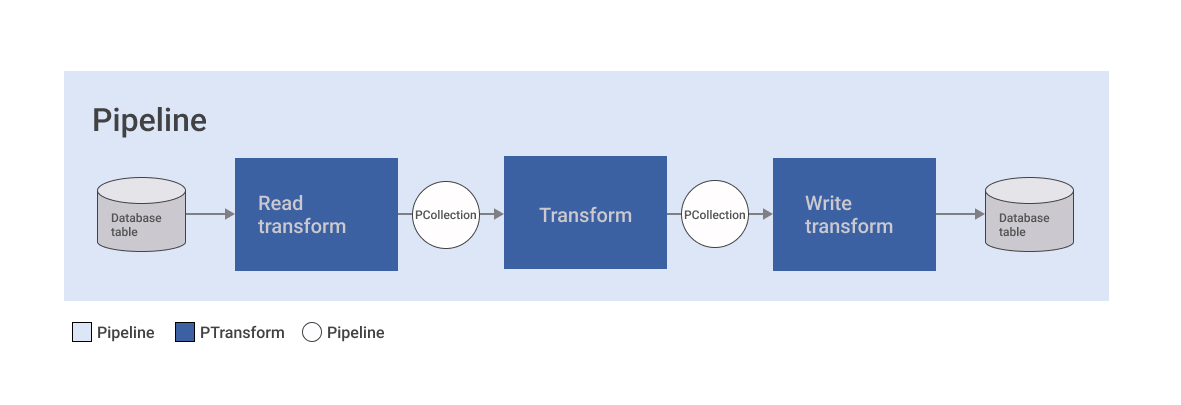

In code, this process will look like this:


```
# Each `step` represents a specific transform. After `step3`, it will save the results to `outputs`.
outputs = pipeline | step1 | step2 | step3
```

>The pipe operator `|`  applies the `PTransform` on the right side of the pipe to the input `PCollection`.


Pipelines can quickly grow long, so it's sometimes easier to read if we surround them with parentheses and break them into multiple lines.

```
# This is equivalent to the example above.
outputs = (
  pipeline
  | step1
  | step2
  | step3
)
```



Sometimes, the transform names aren't very descriptive. Beam allows each transform, or step, to have a unique label, or description. This makes it a lot easier to debug, and it's in general a good practice to start.

> You can use the right shift operator `>>` to add a label to your transforms, like `'My description' >> MyTransform`.

```
# Try to give short but descriptive labels.
# These serve both as comments and help debug later on.
outputs = (
  pipeline
  | 'First step' >> step1
  | 'Second step' >> step2
  | 'Third step' >> step3
)
```

## 1.2 Loading Our Data

Now, you can try to write your own pipeline!

First, let's load the example data we will be using throughout this tutorial into our file directory. This [dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) consists of a **collection of SMS messages in English tagged as either "spam" or "ham" (a legitimate SMS
)**.

For this tutorial, we will create a pipeline to **clean up the dataset to make it easier to create a classifier in Beam to detect which SMS are spam and which are ham**.

In [ ]:
# Creates a data directory with our dataset SMSSpamCollection
!mkdir -p data
!gsutil cp gs://apachebeamdt/SMSSpamCollection data/

**What does the data look like?**

This dataset is a `txt` file with 5,574 rows and 4 columns recording the following attributes:
1. `Column 1`: The label (either `ham` or `spam`)
2. `Column 2`: The SMS as raw text (type `string`)

## 1.3 Writing Our Own Pipeline

Now that we understand our dataset, let's go into creating our pipeline.


To initialize a `Pipeline`, you first assign your pipeline `beam.Pipeline()` to a name. Assign your pipeline to the name, `pipeline`, in the code cell below.

In [ ]:
#@title Edit This Code Cell
...

In [ ]:
#@title Answer
pipeline = beam.Pipeline()

This pipeline will be where we create our transformed `PCollection`. In Beam, your data lives in a `PCollection`, which stands for `Parallel Collection`.

A **PCollection** is like a list of elements, but without any order guarantees. This allows Beam to easily parallelize and distribute the `PCollection`'s elements.

Now, let's use one of Beam's `Read` transforms to turn our text file (our dataset) into a `PCollection`.

## 1.4 Reading from Text File

We can use the
[`ReadFromText`](https://beam.apache.org/releases/pydoc/current/apache_beam.io.textio.html#apache_beam.io.textio.ReadFromText)
transform to read text files into `str` elements.

It takes a
[_glob pattern_](https://en.wikipedia.org/wiki/Glob_%28programming%29)
as an input, and reads all the files that match that pattern. For example, in the pattern `data/*.txt`, the `*` is a wildcard that matches anything. This pattern matches all the files in the `data/` directory with a `.txt` extension. It then **returns one element for each line** in the file.


Because we only want this pipeline to read the `SMSSpamCollection` file that's in the `data/` directory, we will specify the input pattern to be `'data/SMSSpamCollection'`.

We will then use that input pattern with our transform `beam.io.ReadFromText()` and apply it onto our pipeline. The `beam.io.ReadFromText()` transform can take in an input pattern as an input.

In [ ]:
#@title Hint
# If you get stuck on the syntax, use the Table of Contents to navigate to 1.1.1 What is a Pipeline and reread that section.

In [ ]:
#@title Edit This Code

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
  pipeline
  | beam.io.ReadFromText(inputs_pattern)
)

In [ ]:
#@title Answer
inputs_pattern = 'data/SMSSpamCollection'

# Remember: | is the apply function in Beam in Python
outputs = (
    pipeline
      # Remember to add short descriptions to your transforms for good practice and easier understanding
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
)

## 1.5 Writing to Text File

Now, how do we know if we did it correctly? Let's take a look at the text file you just read.

You may have noticed that we can't simply `print` the output `PCollection` to see the elements. In Beam, you can __NOT__ access the elements from a `PCollection` directly like a Python list.

This is because, depending on the runner,
the `PCollection` elements might live in multiple worker machines.

However, we can see our output `PCollection` by using a [`WriteToText`](https://beam.apache.org/releases/pydoc/2.27.0/apache_beam.io.textio.html#apache_beam.io.textio.WriteToText) transform to turn our `str` elements into a `txt` file (or another file type of your choosing) and then running a command to show the head of our output file.

> `beam.io.WriteToText` takes a _file path prefix_ as an input, and it writes the all `str` elements into one or more files with filenames starting with that prefix.
> You can optionally pass a `file_name_suffix` as well, usually used for the file extension.
> Each element goes into its own line in the output files.

Now, you can try it. Save the results to a file path prefix `'output'` and make the file_name_suffix `'.txt'`

In [ ]:
#@title Edit This Code
inputs_pattern = 'data/SMSSpamCollection'

# Remember: | is the apply function in Beam in Python
outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      | 'Write results' >> beam.io.WriteToText(..., file_name_suffix = ...)
      # To see the results
      | 'Print results' >> beam.Map(print)
)

# To run the pipeline
pipeline.run()

# The command used to view your output txt file.
# If you choose to save the file path prefix to a different location or change the file type,
# you have to update this command as well.
! head output*.txt

> *`!` means "run" for Apache Beam*

In [ ]:
#@title Answer
inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      # ADDED
      | 'Write results' >> beam.io.WriteToText("ansoutput1", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

# The file this data is saved to is called "ansoutput1" as seen in the WriteToText transform.
# The command below and the transform input should match.
! head ansoutput1*.txt

# 2. PTransforms

Now that we have read in our code, we can now process our data and clean it up. Remember that the purpose of this pipeline is to **clean up our data to derive features** to use in a classifier that detects spam emails from non-spam (ham) SMS.

In order to clean up our data, we need to use `PTransforms`.

A **`PTransform`** is any data processing operation that performs a processing function on one or more `PCollection`, outputting zero or more `PCollection`.

Some PTransforms accept user-defined functions that apply custom logic, which you will learn in the *Advanced Transforms* notebook. The “P” stands for “parallel.”

## 2.1 Map

One feature to use for the classifier to distinguish spam SMS from ham SMS is to compare the distribution of common words between the two categories. To find the common words for the two categories, we want to perform a frequency count of each word in the data set.

First, because the data set is read line by line, let's clean up the `PCollection` so that the label and the SMS is separated.

To do so, we will use the transform `Map`, which takes a **function** and **maps it** to **each element** of the collection and transforms a single input `a` to a single output `b`.

In this case, we will use `beam.Map` which takes in a lambda function and uses regex to split the line into a two item list: [label, SMS]. The lambda function we will use is `lambda line: line.split("\t")`, which splits each element of the `PCollection` by tab and putting them into a list.


Add a line of code between the `ReadFromText` and `WriteToText` transform that applies a `beam.Map` transform that takes in the function described above. Remember to add a short description for your transform!

In [ ]:
#@title Edit This Code
import re

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      ...
      | 'Write results' >> beam.io.WriteToText("output2", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

! head output2*.txt

In [ ]:
#@title Answer
import re

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      # ADDED
      | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
      | 'Write results' >> beam.io.WriteToText("ansoutput2", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

! head ansoutput2*.txt

## 2.2 Filter

Now that we have a list separating the label and the SMS, let's first focus on only counting words with the **spam** label. In order to process certain elements while igorning others, we want to filter out specific elements in a collection using the transform `Filter`.

`beam.Filter` takes in a function that checks a single element a, and returns True to keep the element, or False to discard it.

In this case, we want `Filter` to return true if the list contains the label **spam**.

We will use a lambda function again for this example, but this time, you will write the lambda function yourself. Add a line of code after your `beam.Map` transform to only return a `PCollection` that only contains lists with the label **spam**.

In [ ]:
#@title Edit This Code
import re

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
      ...
      | 'Write results' >> beam.io.WriteToText("ansoutput3", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

! head ansoutput3*.txt

In [ ]:
#@title Answer
import re

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
      # ADDED
      | 'Keep only spam' >> beam.Filter(lambda line: line[0] == "spam")
      | 'Write results' >> beam.io.WriteToText("ansoutput3", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

! head ansoutput3*.txt

## 2.3 FlatMap

Now, that we know we only have SMS labelled spam, we now need to change the element such that instead of each element being a list containing the label and the SMS, each element is a word in the SMS.

We can't use `Map`, since `Map` allows us to transform each individual element, but we can't change the number of elements with it.

Instead, we want to map a function to each element of a collection. That function returns a list of output elements, so we would get a list of lists of elements. Then we want to flatten the list of lists into a single list.

To do this, we will use `FlatMap`, which takes a **function** that transforms a single input a into an **iterable of outputs** b. But we get a **single collection** containing the outputs of all the elements. In this case, all these elements will be the words found in the SMS.

Add a `FlatMap` transform that takes in the function `lambda line: re.findall(r"[a-zA-Z']+", line[1])` to your code below. The lambda function finds words by finding all elements in the SMS that match the specifications of the regex.

In [ ]:
#@title Edit This Code
import re

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
      | 'Keep only spam' >> beam.Filter(lambda line: line[0] == "spam")
      ...
      | 'Write results' >> beam.io.WriteToText("ansoutput3", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

! head ansoutput3*.txt

In [ ]:
#@title Answer
import re

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
      | 'Keep only spam' >> beam.Filter(lambda line: line[0] == "spam")
      # ADDED
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line[1]))
      | 'Write results' >> beam.io.WriteToText("ansoutput3", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

! head ansoutput3*.txt

## 2.4 Combine

Now that each word is one element, we have to count up the elements. To do that we can use [aggregation](https://beam.apache.org/documentation/transforms/python/overview/) transforms, specifically `CombinePerKey` in this instance which transforms an iterable of inputs a, and returns a single output a based on their key.

Before using `CombinePerKey` however, we have to associate each word with a numerical value to then combine them.

To do this, we add `| 'Pair words with 1' >> beam.Map(lambda word: (word, 1))` to the `Pipeline`, which associates each word with the numerical value 1.

With each word assigned to a numerical value, we can now combine these numerical values to sum up all the counts of each word. Like the past transforms, `CombinePerKey` takes in a function and applies it to each element of the `PCollection`.

However, instead of writing our own lambda function, we can use pass one of Beam's built-in function `sum` into `CombinePerKey`.

In [ ]:
#@title Edit This Code
import re

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
      | 'Keep only spam' >> beam.Filter(lambda line: line[0] == "spam")
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line[1]))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      ...
      | 'Write results' >> beam.io.WriteToText("ansoutput4", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

! head ansoutput4*.txt

In [ ]:
#@title Answer
import re

inputs_pattern = 'data/SMSSpamCollection'

outputs = (
    pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
      | 'Keep only spam' >> beam.Filter(lambda line: line[0] == "spam")
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line[1]))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      # ADDED
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Write results' >> beam.io.WriteToText("ansoutput4", file_name_suffix = ".txt")
      | 'Print results' >> beam.Map(print)
)

pipeline.run()

! head ansoutput4*.txt

And we finished! Now that we have a count of all the words in our data set, it makes it much easier for us to use this feature to create a logistic regression model to detect spam texts.



---



---



# Full Spam Ham Apache Beam Example

Below is a summary of all the code we performed for your convenience. Note you do not need to explicitly call run with the with statement.

In [ ]:
!pip install --quiet apache-beam
!mkdir -p data
!gsutil cp gs://apachebeamdt/SMSSpamCollection data/

In [ ]:
import apache_beam as beam
import re

inputs_pattern = 'data/SMSSpamCollection'
outputs_prefix_ham = 'outputs/fullcodeham'
outputs_prefix_spam = 'outputs/fullcodespam'

# Ham Word Count
with beam.Pipeline() as pipeline:
     ham = (
      pipeline
      | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
      | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
      | 'Keep only ham' >> beam.Filter(lambda line: line[0] == "ham")
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line[1]))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Format results' >> beam.Map(lambda word_c: str(word_c))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix_ham, file_name_suffix = ".txt")
    )

# Spam Word Count
with beam.Pipeline() as pipeline1:
  spam = (
    pipeline1
    | 'Take in Dataset' >> beam.io.ReadFromText(inputs_pattern)
    | 'Separate to list' >> beam.Map(lambda line: line.split("\t"))
    | 'Filter out only spam' >> beam.Filter(lambda line: line[0] == "spam")
    | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line[1]))
    | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
    | 'Group and sum' >> beam.CombinePerKey(sum)
    | 'Format results' >> beam.Map(lambda word_c: str(word_c))
    | 'Write results' >> beam.io.WriteToText(outputs_prefix_spam, file_name_suffix = ".txt")
    )

print('Ham Word Count Head')
! head outputs/fullcodeham*.txt

print('Spam Word Count Head')
! head outputs/fullcodespam*.txt

**One more thing: you can also visualize the Beam pipelines!**

Check [this example](https://github.com/apache/beam/blob/master/sdks/python/apache_beam/runners/interactive/examples/Interactive%20Beam%20Example.ipynb) to learn more about the interatvive Beam.

In [ ]:
import apache_beam.runners.interactive.interactive_beam as ib
ib.show_graph(pipeline)